Team HKV: Michael Keller, Henry Herzfeld, Yuri Villanueva

In this report, we attempt to implement RSA in Python. While the C library NTL is preferred by many for large number operations, we chose to invesigate whether Python can achieve the same or better performance than NTL using existing libraries or packages in conjunction with those that we create. Our results will be detailed in this document, in the hopes that they can be compared with those of other groups in order to make this determination.

# Naive RSA Decryption vs CRT Decryption

First, we were asked to investigate the difference in performance between a naive RSA implementation and an RSA implementation that uses the Chinese Remainder Theorem. 

First, we must perform key generation. Let $N=pq$ be the product of two large primes of the same size ($n/2$ bits each, where $n$ is the key size).

Let $e$, $d$ be two integers satisfiyng $ed=1 (mod  lambda(N))$ where $lambda(N)=lcm((p-1), (q-1))$ is the order of $Z_n$.

We call $N$ the RSA modulus, $e$ the encryption exponent, and $d$ the decryption exponent.

The pair $<N, e>$ is the public key that is used to encrypt messages. We represent it as an ordered pair in our implementation.

The pair $<N, d>$ is the private key which is known only to the intended recipient(s) of messages. It is used for message decryption. It is also represented as an ordered pair in our implementation.

So, note that the variable "public key" contains the pair $(N, e)$ and the variable "private_key" contains the the pair $(N, d)$.

We create three different RSA schemes to generate keys with. The first uses a bitwise powmodn function. The second uses an optimized recursive powmodn function with tail recursion. The third invokes the Python library gmpy2, which pulls in some C packages to speed up decryption. Of all steps in the RSA procedure, key generation takes the most time by far. We will run the RSA process with each of these powmodn functions for decryption and compare their running times over an average of 10 runs. To this end, we must first create key sizes that are powers of 2 from 128 bits up to 4096 bits for comparison. 

We do this for each RSA scheme that we have created, resulting in 3 sets of keys of size 128 to 4096 in powers of 2. We merge these results into a list variable called "keys."

In [1]:
from RSA import RSA
from powmodn import rec_pow_mod_n, bit_pow_mod_n
from util import lcm, int2string, string2int
from math import gcd
from rt import rt2, rt4, rt_average_2, rt_average_4, rt3
import pandas as pd
from tail_optimized import tail_rec_pow_mod_n
from scipy.stats import pearsonr, norm
from scipy import mean, std
import time
import matplotlib.pyplot as plt
from random import randrange

In [2]:
scheme1 = RSA(powmodn=bit_pow_mod_n)
scheme2 = RSA(powmodn=tail_rec_pow_mod_n)
scheme3 = RSA(gmp=True)

schemes = [scheme1, scheme2, scheme3]
keys=[]

for scheme in schemes:
    for i in range (7, 13):
        key=(p, q, n, l, e, d, public_key, private_key)=scheme.generate_keys(bit_length=2**i)
        keys.append(key)

RSA scheme using bit_pow_mod_n and rec_inverse algorithms
RSA scheme using tail_rec_pow_mod_n and rec_inverse algorithms
RSA scheme using powmod and rec_inverse algorithms


Next, we perform encryption with each key size. A message is an integer $M$ in $Z_n$. To encrypt $M$, we compute: 

$$C=M^e (mod N)$$

First, we create a string variable "m" to be our actual message. Then, we convert it to an integer value using byte encoding so that it can be used with the RSA cryptosystem. Then, we perform the encryption computation described above. 

We do this computation for every key in the list "keys". Since RSA encryption is deterministic, we use the same encryption algorithm for all three schemes. It therefore does not matter which scheme's encryption function we call (scheme1, scheme2, scheme3). We merge the resulting ciphertexts into a list variable called "ciphertexts."

In [3]:
message="The quick brown fox jumps over the lazy dog."
print("\nOriginal plaintext message: ", message)

m = string2int(message)
ciphertexts=[]

for i in range(0, (len(keys))):
    c=scheme1.rsa_encrypt(m, key[6])
    ciphertext=int2string(c)
    ciphertexts.append(c)


Original plaintext message:  The quick brown fox jumps over the lazy dog.


Next, we perform decryption with each key size. To decrypt $M$, we the legitimate receiver computes:

$$M=C^d (mod N)$$

It is easy to see from Euler's theorem that:

$$C^d=M^ed=M (mod N)$$

In our implementation, we perform this computation using three different algorithms. The RSA scheme object "scheme1" uses a bitwise powmodn algorithm. The RSA scheme object scheme2 uses an optimized recursive powmodn algorithm that uses tail recursion. The RSA scheme object scheme3 uses the library gmpy2, which has its own optimized powmodn algorithm.

We will use the "scheme1" decryption algorithm on the first set of ciphertexts computed using the first set of keys. We will use the "scheme2" decryption algorithm on the second set of ciphertexts computed using the second set of keys. We will use the "scheme3" decryption algorithm on the third set of ciphertexts computed using the third set of keys.

For each of these decryption algorithms, we run them alone and then again with the Chinese Remainder Theorem optimization that allows us to compute the multiplicative inverse in $Z_n$ faster. We run each of these algorithms 10 times and compute the average running time over the 10 runs. Then, we store these averages in list variables. Then, we use these list values to create three tables of running time values. The first table will compare the running time of each of 6 decryption algorithms:

1. Bitwise without CRT
2. Bitwise CRT
3. Tail Recursion without CRT
4. Tail Recursion CRT
5. GMP without CRT
6. GMP CRT

The second table will compare the running time of the first 4 above algorithms. The third table will compare the running time of algorithms 1, 2, 5, and 6.

Then, we use the first table to create a line plot. This line plot plots the running time as a function of key size, for each of the 6 above decryption algorithms.

Then, we use the second table to create a line plot that plots running time as a function of key size for each of the first 4 decryption algorithms.

Finally, we use the third table to create a line plot that plots running time as a function of key size for algorithms 1, 2, 5, and 6.

In [4]:
bit_lengths=[2**(7+i) for i in range(0, (len(keys))//3)]
reg_running_times_bit,CRT_running_times_bit,=[],[]
reg_running_times_rec,CRT_running_times_rec=[],[]
reg_running_times_gmp,CRT_running_times_gmp=[],[]

for i in range(0, (len(keys))//3):
    # Evaluating bit powmodn RSA scheme
    running_time_avg = rt_average_2(scheme1.rsa_decrypt, ciphertexts[i], keys[i][7], 10)
    CRT_running_time_avg = rt_average_4(scheme1.CRT_rsa_decrypt, ciphertexts[i], keys[i][7], keys[i][0], keys[i][1], 10) 
    CRT_running_times_bit.append(CRT_running_time_avg) 
    reg_running_times_bit.append(running_time_avg)

for i in range(len(keys)//3, 2*(len(keys))//3):
    # Evaluating recursive powmodn RSA scheme   
    running_time_avg = rt_average_2(scheme2.rsa_decrypt, ciphertexts[i], keys[i][7], 10)
    CRT_running_time_avg = rt_average_4(scheme2.CRT_rsa_decrypt, ciphertexts[i], keys[i][7], keys[i][0], keys[i][1], 10) 
    reg_running_times_rec.append(running_time_avg)
    CRT_running_times_rec.append(CRT_running_time_avg)
 
for i in range(2*(len(keys))//3, len(keys)):
    # Evaluating GMP-accelerated powmodn RSA scheme 
    running_time_avg = rt_average_2(scheme3.rsa_decrypt, ciphertexts[i], keys[i][7], 10)
    CRT_running_time_avg = rt_average_4(scheme3.CRT_rsa_decrypt, ciphertexts[i], keys[i][7], keys[i][0], keys[i][1], 10) 
    CRT_running_times_gmp.append(CRT_running_time_avg) 
    reg_running_times_gmp.append(running_time_avg)
    
# Creating dataframes for tables
rt_table_6=pd.DataFrame(list(zip(bit_lengths, reg_running_times_bit, CRT_running_times_bit, reg_running_times_rec, CRT_running_times_rec, reg_running_times_gmp, CRT_running_times_gmp)), columns=['Key Size','Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT', 'GMP No CRT', 'GMP CRT'])
rt_table_6

,Key Size,Bitwise No CRT,Bitwise CRT,Recursive No CRT,Recursive CRT,GMP No CRT,GMP CRT
0,128,0.000161,0.000199,0.001639,0.000986,0.000024,0.000111
1,256,0.001115,0.000495,0.003934,0.003140,0.000112,0.000440
2,512,0.002044,0.001604,0.011670,0.005246,0.000837,0.000859
3,1024,0.009722,0.005101,0.039135,0.015306,0.004991,0.002978
4,2048,0.057679,0.026680,0.127871,0.041962,0.039629,0.015057
5,4096,0.378707,0.146856,0.451962,0.196855,0.204788,0.078579


Text(0, 0.5, 'Running Time (sec)')

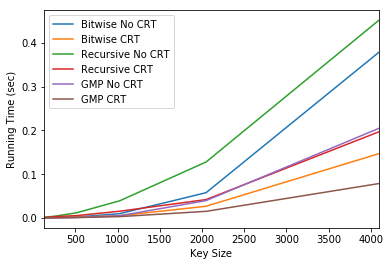

In [5]:
ax_6=rt_table_6.plot(x='Key Size', y=['Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT', 'GMP No CRT', 'GMP CRT'], kind='line')
ax_6.set_ylabel("Running Time (sec)")

In [6]:
rt_table_4=pd.DataFrame(list(zip(bit_lengths, reg_running_times_bit, CRT_running_times_bit, reg_running_times_rec, CRT_running_times_rec)), columns=['Key Size','Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT'])
rt_table_4

,Key Size,Bitwise No CRT,Bitwise CRT,Recursive No CRT,Recursive CRT
0,128,0.000161,0.000199,0.001639,0.000986
1,256,0.001115,0.000495,0.003934,0.003140
2,512,0.002044,0.001604,0.011670,0.005246
3,1024,0.009722,0.005101,0.039135,0.015306
4,2048,0.057679,0.026680,0.127871,0.041962
5,4096,0.378707,0.146856,0.451962,0.196855


Text(0, 0.5, 'Running Time (sec)')

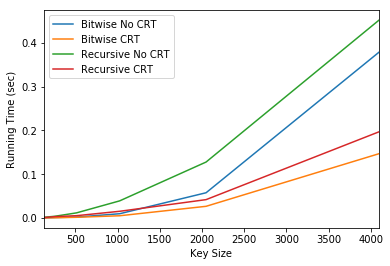

In [7]:
ax_4=rt_table_4.plot(x='Key Size', y=['Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT'], kind='line')
ax_4.set_ylabel("Running Time (sec)")

In [8]:
rt_table_gmp=pd.DataFrame(list(zip(bit_lengths, reg_running_times_bit, CRT_running_times_bit, reg_running_times_gmp, CRT_running_times_gmp)), columns=['Key Size','Bitwise No CRT', 'Bitwise CRT', 'GMP No CRT', 'GMP CRT'])
rt_table_gmp

,Key Size,Bitwise No CRT,Bitwise CRT,GMP No CRT,GMP CRT
0,128,0.000161,0.000199,0.000024,0.000111
1,256,0.001115,0.000495,0.000112,0.000440
2,512,0.002044,0.001604,0.000837,0.000859
3,1024,0.009722,0.005101,0.004991,0.002978
4,2048,0.057679,0.026680,0.039629,0.015057
5,4096,0.378707,0.146856,0.204788,0.078579


Text(0, 0.5, 'Running Time (sec)')

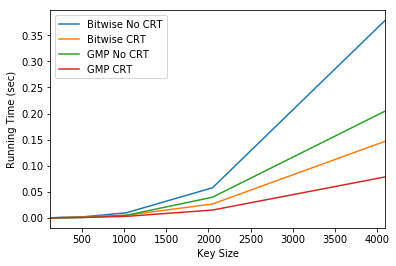

In [9]:
ax_gmp=rt_table_gmp.plot(x='Key Size', y=['Bitwise No CRT', 'Bitwise CRT', 'GMP No CRT', 'GMP CRT'], kind='line')
ax_gmp.set_ylabel("Running Time (sec)")

From the tables and the plots above, we can observe the following:

As expected, the recursive algorithm which does not utilize the Chinese Remainder Theorem performs the slowest out of all algorithms.

As predicted, the GMP implementation which uses the Chinese Remainder Theorem performs the best out of all algorithms. 

As expected, the three implementations which use CRT are all significantly faster than those which do not.

However, we also notice that GMP which does not use CRT starts out comparable to the CRT algorithms, but has a sinificant increase in running time with a key size greater than 2048 bits, making it significantly slower than the CRT algorthms, but still faster than the other non- CRT algorithms. We notice this trend for the other non-CRT algorithms as well, suggesting significant performance degredation past 2048 bits.

# The Random Fault Attack

It was also requested that we implement the random fault attack on the signature of RSA given in the following paper:
https://crypto.stanford.edu/~dabo/pubs/papers/RSA-survey.pdf 

This attack proceeds as follows:

Alice asks Bob to sign a message $m$. Normally, Bob signs the message with his private key $sk$. Alice can verify this signature $s$ using the public key $pk$. It is the same as the original message $m$. 

The random fault attack works on the CRT implementation of RSA decryption. With CRT, RSA signing/decrypting first sends the message $m$ in $Z_n$ to the corresponding element $(u, v)$ in $Z_p x Z_q$. Exponentiation is done in $Z_p x Z_q$ where it is less computationally expensive:

$$x= u^d mod(p-1)(mod p))$$

$$w= v^d mod(p-1)(mod p))$$

Afterwards, send $(x, w)$ in $Z_p x Z_q$ to the corresponding element in $Z_n$. This can be done using the Extended Euclidean Algorithm, where we find $r$ and $t$, the multiplicative inverses of $p$ in $Z_q$, and $q$ in $Z_p$, respectively, so that:

$$rpx + tqw = w (mod p) = x (mod q)$$

is the corresponding element in $Z_n$. This is the signature $s = m ^ d (mod n)$.

Note that $spx = 0 (mod p)$ and $tqw = 0 (mod q)$. The random fault attack can be mounted if exactly one of $w$ or $x$ can be corrupted.

Suppose exactly one of $x$ or $w$ has bit errors, say $x$ becomes $x'$. Then Alice doesn't get the original message $m$ when she verifies the signature. Instead of $s^e (mod n) = m$, Alice gets: 

$$m' = (rpx' + tqw)^e (mod n)= (rpx')^e + (tpq)^e (mod n)$$

The difference between this and $m = s^d = (rpx) ^ e + (tpq) ^ e (mod n)$ is $(rpx') ^ e - (rpx)^e (mod n)$. This difference is equivalent to $0 (mod p)$, and just as important, this difference is nonzero. That is, $m - verify(s', pk) = 0 (mod p)$ and is nonzero. Thus, computing $gcd(n, m - verify(s', pk))$ reveals one of the factors of n. When we introduce even a single bit error in $x$ or $w$, we don't get the original message $m$ when we verify the corrupted signature.

In our implementation, the CRT_rsa_sign function has a 'feature' that lets us introduce a bit error at a random position in either $x$ or $w$. Alice won't get the original message back when she verifies $s$'. The difference between this corrupted message and the original message is equivalent to 0 modulo one of the prime factors of $n$. Alice can recover the factorization by computing the gcd. This factorization should be equal to one of the prime factors of n.

To demonstrate this, we present the following code. We use 1024 bits here for ease of computation.

In [10]:
scheme = RSA(powmodn=bit_pow_mod_n, sign=True)

bit_length = 1024
e = 65537

print("\n\n-------------------------------------------------------------")
print("\nThe random fault attack:")

(p, q, n, l, e, d, public_key, private_key) = scheme.generate_keys(bit_length, e)

message = "Please attach your signature."
print("\n Message to be signed:\n\n\t", message)
m = string2int(message)

s = scheme.rsa_sign(m, private_key, p, q)
print("\n Signature creation successful!")

s1 = scheme.rsa_sign(m, private_key, p, q, faulty=True)  # random bit flip

print("\n Created corrupted signature \n")

m1 = scheme.rsa_verify(s1, public_key)

print("Are m and m' the same? \t", m1==m)

recovered_factor = gcd(n, m - m1)

print("Is recovered_factor=p?\t", recovered_factor==p)
print("Is recovered_factor=q?\t", recovered_factor==q)

RSA scheme using bit_pow_mod_n and rec_inverse algorithms


-------------------------------------------------------------

The random fault attack:

 Message to be signed:

	 Please attach your signature.

 Signature creation successful!

 Created corrupted signature 

Are m and m' the same? 	 False
Is recovered_factor=p?	 False
Is recovered_factor=q?	 True


We note here that $gcd(n, m - m')=p$, verifying the correctness of our fault attack implementation.

# The Timing Attack

Finally, it was also requested that we implement the timing attack on RSA given in the following paper:
https://crypto.stanford.edu/~dabo/pubs/papers/RSA-survey.pdf

This attack proceeds as follows:

Consider a physical data storage device (smartcard, USB device) that stores a private RSA key. It is protected against tampering, so an adversary Marvin cannot simply examine its contents to discover the key. However, the timing attack that we examine can recover the private decryption exponent $d$ by measuring the amount of time it takes the device to perform an RSA decryption.

To demonstrate this attack, we will perform it on the following algorithm:

Let $z=M$ and $C=1.$ Then for each i from 0 to n, we perform:

1. If $d_i=1$, then $C=C*z (mod N)$
2. $z=z^2 (mod N)$

By generating a large number of random messages $M_1, ..., M_k$ in $Z_n$, an adversary Marvin can measure the time $T_i$ it takes to perform decryption and sequentially discover bits of the private exponent $d$. 

Let $t_i$ be the time it takes to compute step 1 of the above. When $d$ is odd (i.e. $d_0=1$), ${T_i}$ and ${t_i}$ are correlated. When $d$ is even, (i.e. $d_0=0$), ${T_i}$ and ${t_i}$ behave as independent random variables. By measuring the correlation, it is possible for Marvin to discover the private exponent d.

In our implentation, we measure $T_i$ and $t_i$ from i=0 to n as described above, then measure the Pearson correlation. If it is above a certain threshold that we define based on our system's timing and hardware, we guess $d_i=1$. Otherwise, $d_i=0$. We present the attack simulation results:

In [11]:
# utility fx for measuring tis
def get_ti(M, n, d):
    t = time.time()

    if d:
        M *= M**2 % n

    return M, time.time()-t

# creating RSA scheme and generating keys, exponents
bits = 16            # bitsize for key generation
scheme = RSA(powmodn=bit_pow_mod_n, sign=True)
p, q, n, l, e, d, public_key, private_key = scheme.generate_keys(bit_length=bits)

simulations = 5     # determines the number of full decryption exp guesses
runs = 500          # determines the test rate of Ti, ti against Mi
n_m = d.bit_length() # number of messages
max_m = 2**1024      # maximum message size
threshold = .05      # statistical significance threshold
final = []

for sim in range(simulations):
    Tis = []
    tis = []

    # creating messages
    messages = [randrange(max_m) for x in range(n_m)]

    for run in range(runs):
        tis_t = []
        Tis_t = []

        # getting Tis and tis for current run
        for m in messages:
            _, t = rt3(scheme.powmodn, m, d, n)
            Tis_t.append(t)

            _, t = get_ti(n, n, 1)
            tis_t.append(t)

        # appending run's Tis/tis to parent list
        Tis.append(Tis_t)
        tis.append(tis_t)

    # printing d and formatting for guessing g, done below
    print('d: {}\n'.format(bin(d)), end='')
    print('g: 0b', end='')

    b = []
    for i in range(n_m):

        # get a list of ti, tis comprising of all runs for m_i
        list_ti = []
        list_Ti = []
        for li in tis:
            list_ti.append(li[i])

        for li in Tis:
            list_Ti.append(li[i])

        # correlation between tis, Tis for m_i for n_runs
        dev, _ = pearsonr(list_Ti, list_ti)        
        # default guess is 0, 1 if std above threshold
        g = 0
        if abs(dev) > threshold:
            g = 1

        print(g, end='')
        b.append(g)

    print('')

    # pairwise intersection testing for each bit of d, g
    res = []
    for act, guess in zip(bin(d)[2:], b):
        res.append(int(act)==guess)

    # calculating accuracy
    result = 0
    n = len(res)
    for eval in res:
        if eval:
            result += eval/n
    print(result)

    final.append(result)

print("Average bitwise accuracy: {:.2f}".format(sum(final) / simulations))

RSA scheme using bit_pow_mod_n and rec_inverse algorithms
d: 0b101010111011000100101
g: 0b011011110100001010001
0.47619047619047616
d: 0b101010111011000100101
g: 0b101000100011001000000
0.6666666666666667
d: 0b101010111011000100101
g: 0b000001000010100000001
0.47619047619047616
d: 0b101010111011000100101
g: 0b010000000000000010000
0.38095238095238093
d: 0b101010111011000100101
g: 0b110000000101100111011
0.38095238095238093
Average bitwise accuracy: 0.48


# APPENDIX

## APPENDIX A- Python

Python is notably poor suited for the execution of recursive algorithms. Each function call, regardless of its composition, allocates a stack frame in Python. When recursing, this large number of nested stack frames dramatically increases execution. One solution for a large stack trace is to optimize for tail recursion.

In [12]:
! tail -12 tail_optimized.py

@TailCaller
def tail_rec_inverse_helper(r, new_r, n, t=0, new_t=1):
    if new_r <= 0:
        return t % n
    else:
        return TailCall(tail_rec_inverse_helper, new_r, r % new_r, n, new_t, t - (r // new_r) * new_t)

# Multiplicative inverse of a in Z_n*
def tail_rec_inverse(a, n):
    if gcd(a, n) != 1:
        return "a is not invertible in Z/nZ"
    return tail_rec_inverse_helper(n, a, n)


The above function definitions describe two functions, one of which performs recursion. The recursive function's return statement has been carefully extracted from its logic such that the call stands alone, at the tail of the recursive function. This is tail recursion. In many languages the compiler will note this tail recursion and perform tail recursion elimination. This effectively removes stack frames from the stack for each recursive call. Instead of performing a CALL/RETURN within the stack, only a JUMP is needed. 

Unfortunately, Python does not support tail recursion elimination explicitly.

In [13]:
! cat tailcaller.py

class TailCaller(object) :
    def __init__(self, f) :
        self.f = f
    def __call__(self, *args, **kwargs) :
        ret = self.f(*args, **kwargs)
        while type(ret) is TailCall :
            ret = ret.handle()
        return ret

class TailCall(object) :
    def __init__(self, call, *args, **kwargs) :
        self.call = call
        self.args = args
        self.kwargs = kwargs
    def handle(self) :
        if type(self.call) is TailCaller :
            return self.call.f(*self.args, **self.kwargs)
        else :
            return self.call(*self.args, **self.kwargs)


The above classes are used to emulate tail recursion elimination. By using the decorator "@TailCaller" on a tail optimized recursive function, we may perform tail recursion elimination within Python. Decorators are wrappers for functions which modify their behavior.

## Appendix B- Kocher's Timing Attack

RSA scheme using powmod and rec_inverse algorithms

Standard deviation of time differences:  5.950603362944249e-07 5.85143037332847e-07

In binary, d =  0b10001100111001100010111101111000001001011001000101111010011001110011001111010110011111010101010111101111100101011011100011011


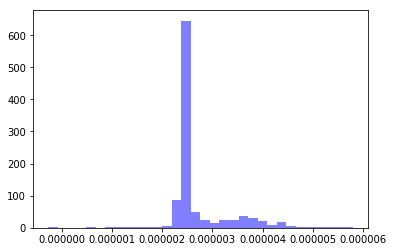

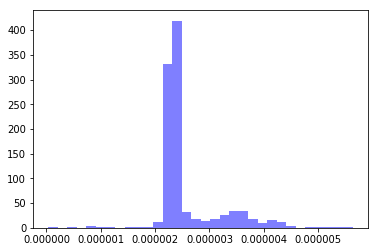

In [14]:
from util import clear_bit_n, set_bit_n, get_last_n_bits, clear_last_n_bits, remove_outliers
from rt import rt3x_average
from gmpy2 import powmod
import numpy as np
from RSA import RSA
from random import randrange
from scipy import mean, std
import matplotlib.pyplot as plt

BL = 128 # The key length in bits. This is the size of n = pq.
NN = 1024 # The number of messages to be signed/decrypted
averages = 100 # number of measurements to be averaged per message

# Generate keys. Keep doing it until we get one where bit b1 of d is 1.
d = 0

scheme = RSA(gmp=True)

while not (d & 2):
    (p, q, n, l, e, d, pk, sk) = scheme.generate_keys(bit_length = BL//2)

M = [randrange(2**BL) for i in range(NN)]

# The guess g. Initial guess is 1, corresponding to b_0 = 1 and all other bits 0.
g = 1


# Get the running times t_i for m_i^x for the messages m_i in M
def measure_times(M, x, n, number_of_runs_per_message = 1):
    return np.array([rt3x_average(powmod, m, x, n, number_of_runs_per_message) for m in M])


TT = measure_times(M, d, n, averages) # These are the T_i's
tt0 = measure_times(M, g, n, averages) # These are the t_i's when g = 0b1

g = set_bit_n(g, 1) # set g to 0b11
tt1 = measure_times(M, g, n, averages) # these are the t_i's when g is 0b11

D0 = remove_outliers(TT - tt0)
D1 = remove_outliers(TT - tt1)


# Compute the standard deviations for the time differences
(sd0, sd1) = map(std, (D0, D1))


print("\nStandard deviation of time differences: ", sd0, sd1)

print("\nIn binary, d = ", bin(d))

num_bins = 32

nn, bins, patches = plt.hist(D0, num_bins, facecolor='blue', alpha=0.5, label='D0')
plt.show()

nn, bins, patches = plt.hist(D1, num_bins, facecolor='blue', alpha=0.5, label='D1')
plt.show()

msg = M[0]
d64 = clear_last_n_bits(d, 64)
b64 = get_last_n_bits(d, 64)

## Appendix C- Van Cuijk's Timing Attack

The timing attack below is as described by Van Cuijk in his paper:
https://phedny.net/papers/Timing%20attacks%20on%20RSA.pdf

This approach introduces the variable $d$ which contains the fixed time difference between one iteration of the bitwise powmodn function for $d_i$ = 0 and $d_i$ = 1. Using the normal distribution density function, defined below as norm.pdf, we can use priori and posteori probabilities, along with Bayes' Theorem to find the probability that $d_i$ = 1.

Unfortunately this implementation does not produce any meaningful probabilities.

In [17]:
mu = mean(Tis_t)
sigma = std(Tis_t)
temp = 1
denominator = 1

for bit in range(bits):
    
    m, t1 = get_ti(m, n, 1)
    m, t2 = get_ti(m, n, 0)
    d =  t1 - t2
    c = t1       #
    t = Tis_t[0]
    
    p_t_given_1 = norm.pdf((t-c-d - mu*(t-c-d)) / sigma*(t-c-d))
    p_t_given_0 = norm.pdf((t-c - mu*(t-c)) / sigma*(t-c))

    p_1_given_t = p_t_given_1 / (p_t_given_1 + p_t_given_0)
    p_0_given_t = p_t_given_0 / (p_t_given_1 + p_t_given_0)
    
    temp *= p_1_given_t
    denominator *= p_0_given_t

denominator += temp
numerator = temp

p_1 = numerator/denominator
print("Probabiliy D0 = 1: {}%".format(100*p_1))

Probabiliy D0 = 1: 49.99998977674776%


## Appendix D- Works Cited

D. Boneh (dabo@cs.stanford.edu). Twenty Years of Attacks on the RSA Cryptosystem. Notices of the American Mathematical Society (AMS), Vol. 46, No. 2, pp. 203-213, 1999

P. Kocher. Timing attacks on implementations of Diffie-Hellman, RSA, DSS, and other systems. In CRYPTO '96, volume 1109 of Lecture Notes in Computer Science, pages 104-113.Springer-Verlag, 1996.

GNU Multiple Precision Arithmetic Library: https://gmplib.org

General Multiprecision Python Project(gmpy2):  https://github.com/aleaxit/gmpy and https://pypi.org/project/gmpy2/ 

Python Cryptography Toolkit (PyCrypto): https://pypi.org/project/pycrypto/ and https://www.dlitz.net/software/pycrypto/api/current/ 

Karatsuba integer multiplication is O(n1.58). M. Cardei, COT 6405 Class Notes, Boca Raton, FL, 2019.

Project Nayuki, "Karatsuba multiplication," Project Nayuki, 14 June 2016. [Online]. Available: https://www.nayuki.io/page/karatsuba-multiplication.

Van Cuijk, M. (2009, March 20). Timing Attacks on RSA. Retrieved from https://phedny.net/papers/Timing attacks on RSA.pdf.